# Compare the performance of different methods

In [1]:
using DataFrames, CSV, BSON
using BSON: @save, @load
using Plots, Plots.Measures, StatsPlots
using LaTeXStrings
using HEMS
using Printf
using Flux, StatsBase
using NPZ
using Random
using Revise, HEMS

Random.seed!(42)
ENV["COLUMNS"] = 2000;

## Load test scenarios

In [2]:
root_dir = "../"
scenario_dir = joinpath(root_dir, "data/learning/scenarios/")
IL_data_dir = joinpath(root_dir, "data/learning/IL")
MARL_data_dir = joinpath(root_dir, "data/learning/MARL")
img_dir = joinpath(root_dir, "img")
IL_model_dir = joinpath(root_dir, "model/IL")

"../model/IL"

In [3]:
# home configuration
home_dir = joinpath(root_dir, "data/home/")
const h = read_home_config(joinpath(home_dir, "home.toml"));

In [4]:
# each scenario in `ss` contains already the solution of ideal MILP
# the solution columns will be replaced by other methods' results later
ss = BSON.load(joinpath(IL_data_dir, "test_ss.bson"))[:ss]
n_test = length(ss)
@show n_test

n_test = 365


365

## Cost of each method

### Ideal MILP
Note that the cost has already been computed in "notebook/IL/IL_data.ipynb" and stored in the data frames.

In [5]:
ideal = zeros(n_test)
for i = 1:n_test
    ideal[i] = sum(ss[i][!, :C])
end

### Day-ahead MILP

In [6]:
"""
    run_da_MILP(s, h) -> Float64

Run day-ahead MILP on `s` and get the total cost.
"""
function run_da_MILP(s, h)
    sda = copy(s)
    # inject 10% noises into PV and price as the day-ahead forecasting
    T = size(s)[1]
    strength = 0.3
    sda.PPV .+= randn(T) .* range(0.2, 0.5, T) .* sda.PPV
    # do not allow negative PV
    replace!(v -> max(v, 0.0), sda.PPV)
    sda.ρ .+= randn(T) .* range(0.2, 0.5, T) .* sda.ρ
    # do not allow negative price
    replace!(v -> max(v, 0.0), sda.ρ)

    # run MILP
    run_MILP!(sda, h)

    # set the true values of PV and price to compute the actual cost
    sda.PPV .= s.PPV
    sda.ρ .= s.ρ
    # compute the cost
    return compute_cost!(sda, h)
end

run_da_MILP

In [7]:
da = zeros(n_test)
for i = 1:n_test
    da[i] = run_da_MILP(ss[i], h)
end


### MARL 
The implementation is in Python. We simply read the results here for visualization.

In [8]:
ql = npzread(joinpath(MARL_data_dir, "QL/QLearningTestCostFixed.npy"))
dqn = npzread(joinpath(MARL_data_dir, "DQN/DQNTestCost.npy"));

### MAIL

In [5]:
# agents of shiftable loads
@load joinpath(IL_model_dir, "agents.bson") agents;

In [10]:
"""
    run_MAIL(s, h, shift_agents) -> Float64

Run MAIL on scenario `s` with home `h` and the shiftable loads' agents `shift_agents`.
The total cost is returned.
"""
function run_MAIL(s, h, shift_agents)
    # first run our hybrid method to get the actions of shiftable loads
    sr = manage_loads(s, h, shift_agents)
    # set the actions of adjustable loads by certain uncertainty
    # note that `s` contains the expert action
    T = nrow(s)
    strength = 0.2
    for l in h["AD"]
        id = l["id"]
        Pmax, Pmin = l["Pmax"], l["Pmin"]
        sr[:, "P_$id"] .= s[!, "P_$id"] .+ randn(T) .* strength .* s[!, "P_$id"]
        # enforce the constraint 
        replace!(v -> max(Pmin, min(v, Pmax)), sr[!, "P_$id"])
    end
    # compute the cost and write necessary columns in `sr` in place
    return compute_cost!(sr, h)
end

run_MAIL (generic function with 1 method)

In [11]:
mail = zeros(n_test)
for i = 1:n_test
    mail[i] = run_MAIL(ss[i], h, agents)
end

### Hybrid method

In [10]:
# measure execution time: each scenario has 24 steps
total_time = @timed begin
    for i = 1:n_test
        sh = manage_loads(ss[i], h, agents)
    end
end
;

In [11]:
# average execution time of each step 
exe_time = total_time.time / n_test / nrow(ss[1]) 
println("Average execution time is $(exe_time * 1000) ms")

Average execution time is 5.994460833333333 ms


In [12]:
hybrid = zeros(n_test)
for i = 1:n_test
    sh = manage_loads(ss[i], h, agents)
    hybrid[i] = compute_cost!(sh, h)
end

## Plot relative cost

In [13]:
da_rel = (da .- ideal) ./ ideal * 100
mean(da_rel), extrema(da_rel)

(4.44221363221768, (1.0296096296635464, 16.63010658261841))

In [14]:
ql_rel = (ql .- ideal) ./ ideal .* 100
mean(ql_rel), extrema(ql_rel)

(8.780027363151007, (3.1981458626434147, 24.97384816555136))

In [15]:
dqn_rel = (dqn .- ideal) ./ ideal .* 100
mean(dqn_rel), extrema(dqn_rel)

(6.368333565791371, (1.0751891269760734, 23.633563783239524))

In [16]:
mail_rel = (mail .- ideal) ./ ideal .* 100
mean(mail_rel), extrema(mail_rel)

(5.780080602962472, (1.5738551142589132, 12.878501566692794))

In [17]:
hybrid_rel = (hybrid .- ideal) ./ ideal .* 100
# the extremely small negative value is due to numerical roundoff errors 
hybrid_rel = max.(hybrid_rel, 0.0)
mean(hybrid_rel), extrema(hybrid_rel)

(1.2771299750922183, (0.0, 6.34630047819378))

In [18]:
default(; labelfontsize = 13, tickfontsize = 11,
    framestyle = :box,
    margin = 0.5mm,
    legendfontsize=11,
    legend=false
)

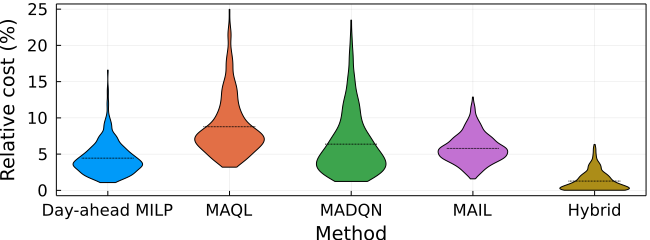

In [19]:
violin(repeat(["Day-ahead MILP" "MAQL" "MADQN" "MAIL" "Hybrid"],outer=length(n_test)),[da_rel ql_rel dqn_rel mail_rel hybrid_rel]; 
    size=(650, 240), show_mean=true,
    xlabel="Method", ylabel="Relative cost (%)",
    bottom_margin=3mm, top_margin=-1mm, left_margin=2mm, right_margin=-1mm)
savefig(joinpath(img_dir, "methods.pdf"))
current()